正在严格查找指定的字体: 'SimHei'...
成功找到字体 'SimHei'，路径: C:\Windows\Fonts\simhei.ttf

开始生成综合可视化图表: 房地产业扩净增变更情况 (2023-2025)
开始读取和预处理【月度净增容量】数据...
开始读取和预处理【累计同比】数据...
数据截断与重塑完成。

图表已成功保存到: E:\A智网\业扩分析\12月分析\11月业扩月度报告\附录图\房地产_分析图.png


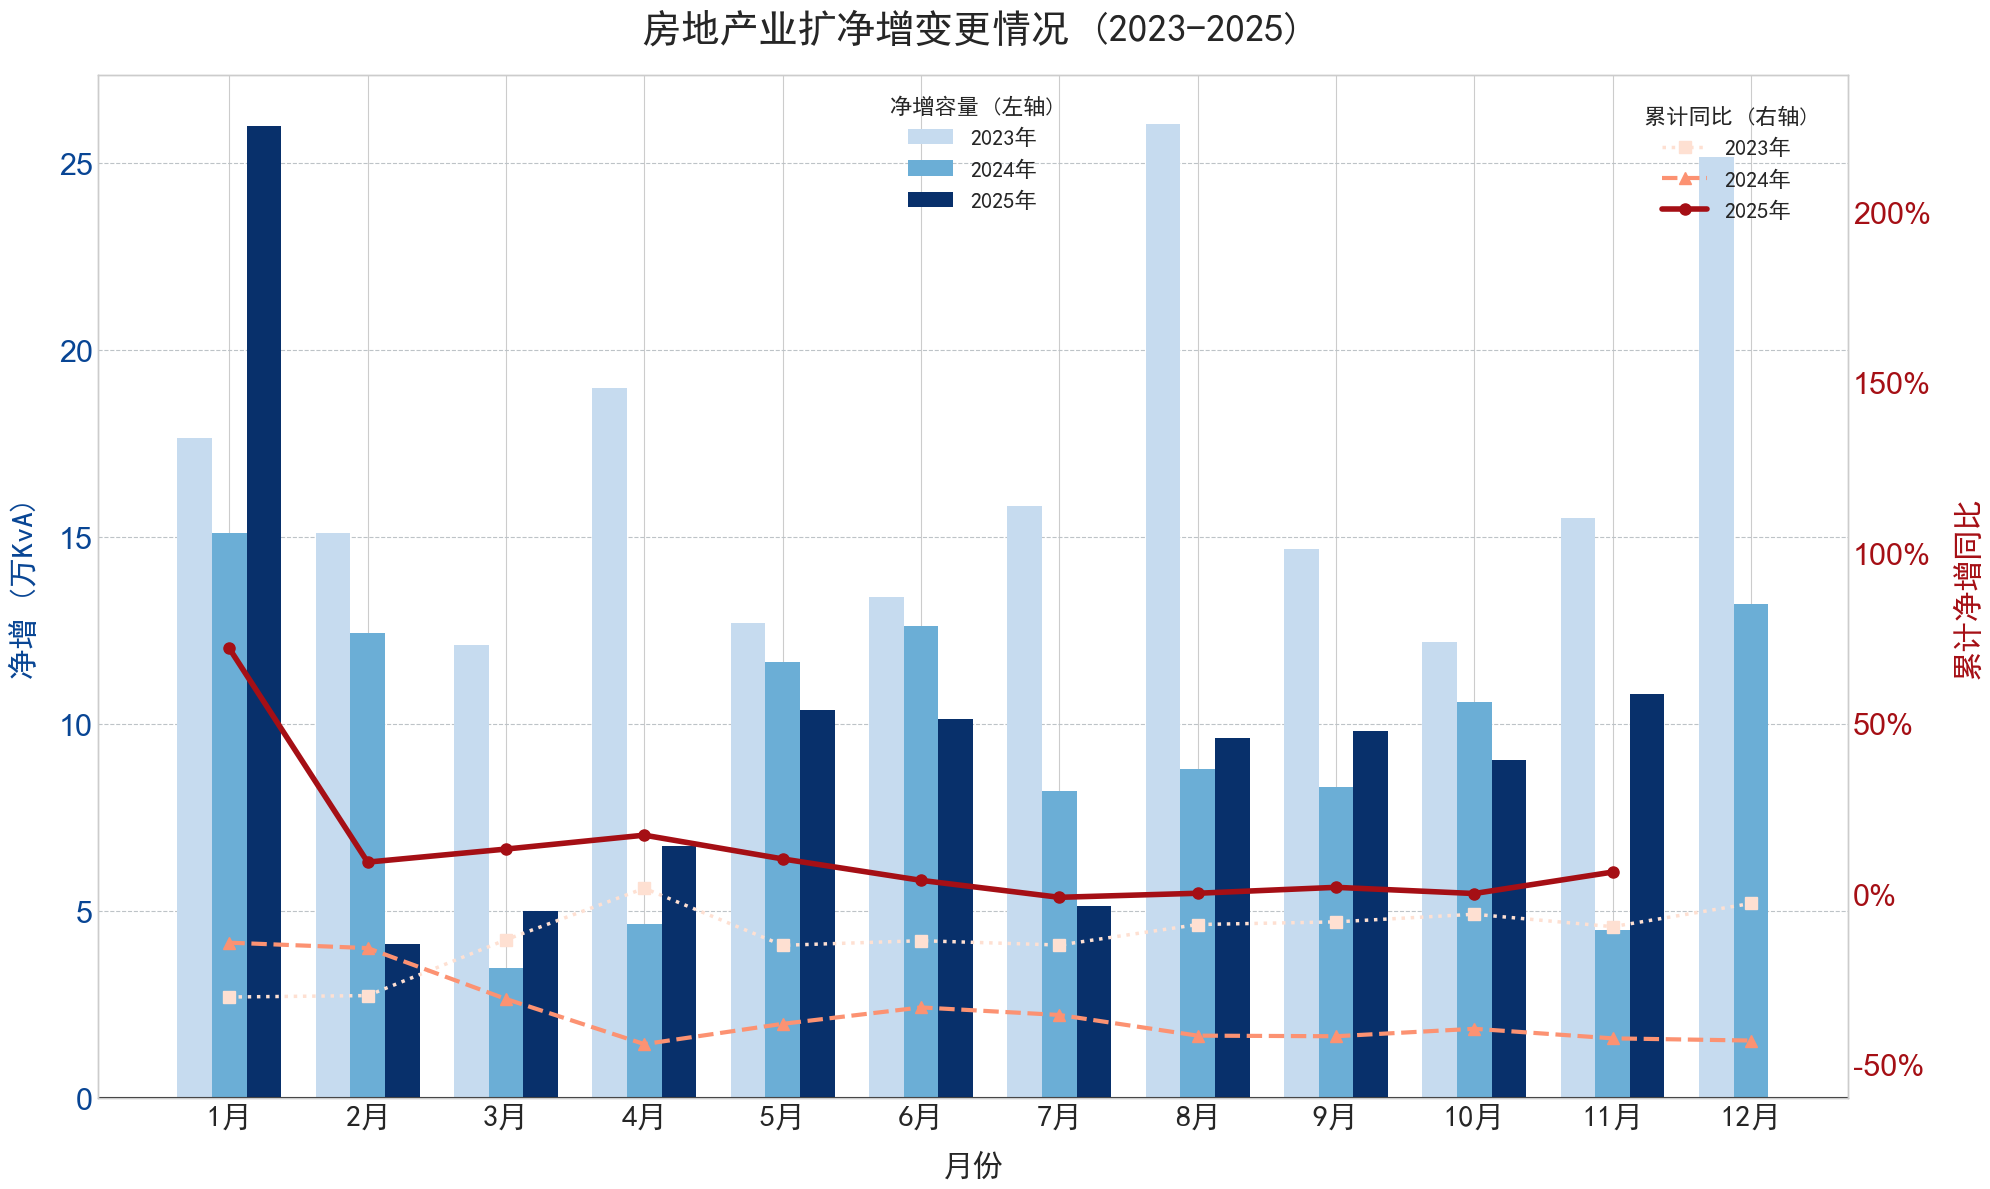

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import Optional, List, Dict, Tuple
from matplotlib import font_manager
import numpy as np
from matplotlib.legend import Legend

# ==============================================================================
# 1. 配置层 (Configuration Layer)
# ==============================================================================
class Config:
    """集中管理所有绘图的配置参数"""
    BASE_PATH = Path(r'E:\A智网\业扩分析\26年1月分析\12月业扩月度报告')
    
    FILE_NET_INCREASE = BASE_PATH / '25年12月业扩报告_新装增容业扩.xlsx'
    FILE_NET_DECREASE = BASE_PATH / '25年12月业扩报告_减容销户业扩.xlsx'
    FILE_YOY_TREND = BASE_PATH / '业扩月度累计净增容量趋势分析.xlsx'

    TARGET_CATEGORY_NAME = '全行业总计' #改这里
    CHART_TITLE_NAME = '全社会' #改这里
    OUTPUT_IMAGE_FILE = BASE_PATH / f'附录图/{CHART_TITLE_NAME}_分析图.png'

    SHEET_NET_INC_CAP = '完成新装增容_容量'
    SHEET_NET_DEC_CAP = '完成减容销户_容量'
    SHEET_YOY_TREND = '累计净增容量同比'
    
    CHART_TITLE = f'{CHART_TITLE_NAME}业扩净增变更情况 (2023-2025)'
    X_AXIS_LABEL = '月份'
    
    Y1_AXIS_LABEL = '净增 (万KvA)'
    Y1_AXIS_COLOR = '#084594'
    
    Y2_AXIS_LABEL = '累计净增同比'
    Y2_AXIS_COLOR = '#A50F15'

    # --- 【关键】在这里修改Y轴范围 ---
    Y2_AXIS_UPPER_LIMIT = 2.0  # 4000%   #改这里
    Y2_AXIS_LOWER_LIMIT = -0.5  # -500%   #改这里

    TARGET_FONT = 'SimHei'
    CHART_TITLE_FONTSIZE = 28
    AXIS_LABEL_FONTSIZE = 22
    TICK_LABEL_FONTSIZE = 22
    LEGEND_FONTSIZE = 16
    LEGEND_TITLE_FONTSIZE = 16

# ==============================================================================
# 2. 辅助函数层 (Helper Functions)
# ==============================================================================

def find_specific_font(font_name: str) -> Optional[font_manager.FontProperties]:
    # ... (此函数保持不变) ...
    print(f"正在严格查找指定的字体: '{font_name}'...")
    font_files = font_manager.fontManager.ttflist
    for font_file in font_files:
        if font_file.name == font_name:
            print(f"成功找到字体 '{font_name}'，路径: {font_file.fname}")
            return font_manager.FontProperties(fname=font_file.fname)
    print(f"[致命错误] 未能在系统中找到指定的字体 '{font_name}'。")
    return None

def preprocess_net_increase_data(file_new_inc: Path, file_dec_term: Path, sheet_inc: str, sheet_dec: str, target_category: str) -> Optional[pd.DataFrame]:
    # ... (此函数保持不变) ...
    print("开始读取和预处理【月度净增容量】数据...")
    try:
        df_inc = pd.read_excel(file_new_inc, sheet_name=sheet_inc, index_col='分类')
        df_dec = pd.read_excel(file_dec_term, sheet_name=sheet_dec, index_col='分类')
        df_inc.columns = df_inc.columns.map(str)
        df_dec.columns = df_dec.columns.map(str)
        
        common_cols = df_inc.columns.intersection(df_dec.columns)
        net_increase_df = df_inc[common_cols].subtract(df_dec[common_cols], fill_value=0)
        net_increase_df = net_increase_df.reset_index()
        
        target_data = net_increase_df[net_increase_df['分类'].str.strip() == target_category.strip()]
        if target_data.empty:
            print(f"[错误] 在【月度净增容量】数据中未找到目标分类: '{target_category}'")
            return None
            
        long_df = target_data.iloc[0].drop('分类').reset_index()
        long_df.columns = ['年月', '净增容量']
        long_df = long_df[long_df['年月'].str.match(r'^\d{6}$')].copy()
        long_df['净增容量'] = pd.to_numeric(long_df['净增容量'], errors='coerce') / 10000
        long_df['年份'] = long_df['年月'].str[:4]
        long_df['月份'] = long_df['年月'].str[4:].astype(int)
        
        target_years = ['2023', '2024', '2025']
        long_df = long_df[long_df['年份'].isin(target_years)]
        
        return long_df.pivot(index='月份', columns='年份', values='净增容量')
    except Exception as e:
        print(f"[致命错误] 处理【月度净增容量】数据时出错: {e}")
        return None


# --- 【核心修正】重构数据处理流程，确保截断逻辑生效 ---
def preprocess_yoy_data(file_path: Path, sheet_name: str, target_category: str) -> Optional[Tuple[pd.DataFrame, List[Dict]]]:
    """
    读取、预处理并截断“累计同比”数据。
    返回一个元组: (用于绘图的截断后DataFrame, 需要标注的异常点列表)
    """
    print("开始读取和预处理【累计同比】数据...")
    try:
        if not file_path.exists():
            print(f"[致命错误] 输入文件不存在: {file_path}")
            return None, None
            
        # 1. 读取数据，确保我们操作的是一个副本
        df_wide = pd.read_excel(file_path, sheet_name=sheet_name).copy()
        
        # 2. 筛选目标行业
        df_target = df_wide[df_wide['分类'].str.strip() == target_category.strip()].copy()
        if df_target.empty:
            print(f"[错误] 在文件中未找到目标分类: '{target_category}'。")
            return None, None
            
        # 3. 宽表转长表
        id_vars = ['序号', '分类']
        value_vars = [col for col in df_target.columns if col not in id_vars]
        df_long = df_target.melt(id_vars=id_vars, value_vars=value_vars, var_name='年月', value_name='同比增长率_str')
        
        # 4. 清洗和转换数据
        #    使用 .loc 避免 SettingWithCopyWarning
        df_long.loc[:, '同比增长率'] = df_long['同比增长率_str'].astype(str).str.rstrip('%').replace('N/A', pd.NA)
        df_long.loc[:, '同比增长率'] = pd.to_numeric(df_long['同比增长率'], errors='coerce') / 100.0
        
        df_long.loc[:, '年份'] = df_long['年月'].str[:4]
        df_long.loc[:, '月份'] = df_long['年月'].str[4:].astype(int)
        
        # 5. 筛选年份
        target_years = ['2023', '2024', '2025']
        df_long = df_long[df_long['年份'].isin(target_years)].copy()
        
        # 6. 【核心修正】先截断，再透视
        annotations = []
        # 创建一个新的列用于存储截断后的值
        df_long['同比增长率_capped'] = df_long['同比增长率']

        for index, row in df_long.iterrows():
            original_value = row['同比增长率']
            if pd.notna(original_value):
                capped_value = original_value
                if original_value > Config.Y2_AXIS_UPPER_LIMIT:
                    capped_value = Config.Y2_AXIS_UPPER_LIMIT
                    annotations.append({'x': row['月份'], 'y': capped_value, 'text': f'{original_value:.0%}'})
                elif original_value < Config.Y2_AXIS_LOWER_LIMIT:
                    capped_value = Config.Y2_AXIS_LOWER_LIMIT
                    annotations.append({'x': row['月份'], 'y': capped_value, 'text': f'{original_value:.0%}'})
                
                # 使用 .at 精确赋值
                df_long.at[index, '同比增长率_capped'] = capped_value
        
        # 7. 使用截断后的数据进行透视
        plot_df_capped = df_long.pivot(index='月份', columns='年份', values='同比增长率_capped')
        
        print("数据截断与重塑完成。")
        return plot_df_capped, annotations

    except Exception as e:
        print(f"[致命错误] 处理【累计同比】数据时出错: {e}")
        return None, None

# ==============================================================================
# 3. 主流程 (Main Logic)
# ==============================================================================
def main():
    """主执行函数"""
    
    # --- 字体设置 ---
    base_font_prop = find_specific_font(Config.TARGET_FONT)
    if base_font_prop is None: return
    font_path = base_font_prop.get_file()
    if not font_path: return
    title_font = font_manager.FontProperties(fname=font_path, size=Config.CHART_TITLE_FONTSIZE, weight='bold')
    axis_label_font = font_manager.FontProperties(fname=font_path, size=Config.AXIS_LABEL_FONTSIZE)
    tick_label_font = font_manager.FontProperties(fname=font_path, size=Config.TICK_LABEL_FONTSIZE)
    legend_text_font = font_manager.FontProperties(fname=font_path, size=Config.LEGEND_FONTSIZE)
    legend_title_font = font_manager.FontProperties(fname=font_path, size=Config.LEGEND_TITLE_FONTSIZE, weight='bold')
    
    print(f"\n开始生成综合可视化图表: {Config.CHART_TITLE}")
    
    # --- 数据处理 ---
    df_net_increase = preprocess_net_increase_data(Config.FILE_NET_INCREASE, Config.FILE_NET_DECREASE, Config.SHEET_NET_INC_CAP, Config.SHEET_NET_DEC_CAP, Config.TARGET_CATEGORY_NAME)
    df_yoy_capped, annotations = preprocess_yoy_data(Config.FILE_YOY_TREND, Config.SHEET_YOY_TREND, Config.TARGET_CATEGORY_NAME)
    
    if df_net_increase is None or df_yoy_capped is None:
        print("因数据读取或处理失败，无法生成图表。")
        return
    
    # --- 绘图 ---
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax1 = plt.subplots(figsize=(20, 12))
    
    ax2 = ax1.twinx()
    
    years = ['2023', '2024', '2025']
    
    bar_width = 0.25
    index = np.arange(1, 13)
    
    colors1 = {'2023': '#C6DBEF', '2024': '#6BAED6', '2025': '#08306B'}
    
    bar1 = ax1.bar(index - bar_width, df_net_increase.get('2023', 0), bar_width, label='2023年', color=colors1['2023'])
    bar2 = ax1.bar(index, df_net_increase.get('2024', 0), bar_width, label='2024年', color=colors1['2024'])
    bar3 = ax1.bar(index + bar_width, df_net_increase.get('2025', 0), bar_width, label='2025年', color=colors1['2025'])

    colors2 = {'2023': '#FEE0D2', '2024': '#FC9272', '2025': '#A50F15'}
    linestyles = {'2023': ':', '2024': '--', '2025': '-'}
    linewidths = {'2023': 2.5, '2024': 3, '2025': 4}
    markers = {'2023': 's', '2024': '^', '2025': 'o'}

    for year in years:
        if year in df_yoy_capped.columns:
            ax2.plot(df_yoy_capped.index, df_yoy_capped[year], 
                     linestyle=linestyles[year], linewidth=linewidths[year],
                     color=colors2[year], marker=markers[year], markersize=8,
                     label=f'{year}年')

    for ann in annotations:
        ax2.annotate(ann['text'], xy=(ann['x'], ann['y']), xytext=(0, 15), textcoords='offset points', ha='center', va='bottom',
                     fontproperties=font_manager.FontProperties(fname=font_path, size=14, weight='bold'), color='blue',
                     arrowprops=dict(arrowstyle='->', color='blue'))

    # --- 美化 ---
    ax1.set_title(Config.CHART_TITLE, fontproperties=title_font, pad=25)
    ax1.set_xlabel(Config.X_AXIS_LABEL, fontproperties=axis_label_font, labelpad=15)
    
    ax1.set_ylabel(Config.Y1_AXIS_LABEL, fontproperties=axis_label_font, color=Config.Y1_AXIS_COLOR, labelpad=15)
    ax1.tick_params(axis='y', labelcolor=Config.Y1_AXIS_COLOR, labelsize=Config.TICK_LABEL_FONTSIZE)
    ax1.grid(True, which='major', axis='y', linestyle='--', color='#BDC3C7')

    ax2.set_ylabel(Config.Y2_AXIS_LABEL, fontproperties=axis_label_font, color=Config.Y2_AXIS_COLOR, labelpad=15)
    ax2.tick_params(axis='y', labelcolor=Config.Y2_AXIS_COLOR, labelsize=Config.TICK_LABEL_FONTSIZE)
    
    # --- 【核心修正】智能调整Y轴下限 ---
    y_upper = Config.Y2_AXIS_UPPER_LIMIT * 1.2
    y_lower = 0
    if Config.Y2_AXIS_LOWER_LIMIT < 0:
        y_lower = Config.Y2_AXIS_LOWER_LIMIT * 1.2
    else:
        # 如果下限是0或正数，我们手动撑开一点空间
        y_lower = - (y_upper * 0.1) # 例如，撑开上限的10%作为负数区域
        
    ax2.set_ylim(y_lower, y_upper)
    # ------------------------------------
    
    ax2.yaxis.set_major_formatter(plt.FuncFormatter('{:.0%}'.format))
    ax2.grid(False)

    ax1.set_xticks(index)
    ax1.set_xticklabels([f'{i}月' for i in range(1, 13)], fontproperties=tick_label_font)
    ax1.axhline(0, color='black', linestyle='-', linewidth=1.5)

    from matplotlib.legend import Legend
    
    leg1 = Legend(ax1, [bar1, bar2, bar3], ['2023年', '2024年', '2025年'],
                  title='净增容量 (左轴)', prop=legend_text_font,
                  loc='best')
    leg1.get_title().set_font_properties(legend_title_font)
    ax1.add_artist(leg1)

    lines2, labels2 = ax2.get_legend_handles_labels()
    leg2 = Legend(ax1, lines2, labels2,
                  title='累计同比 (右轴)', prop=legend_text_font,
                  loc='upper right', bbox_to_anchor=(0.99, 0.99))
    leg2.get_title().set_font_properties(legend_title_font)
    ax1.add_artist(leg2)
    
    fig.tight_layout()
    try:
        plt.savefig(Config.OUTPUT_IMAGE_FILE, dpi=500, bbox_inches='tight')
        print(f"\n图表已成功保存到: {Config.OUTPUT_IMAGE_FILE}")
    except Exception as e:
        print(f"\n[错误] 保存图表失败: {e}")
    plt.show()

if __name__ == '__main__':
    main()

正在严格查找指定的字体: 'SimHei'...

开始生成综合可视化图表: 充换电服务业业扩净增变更情况 (2023-2025)
开始读取和预处理【月度净增容量】数据...
开始读取和预处理【累计同比】数据...
数据截断与重塑完成。

图表已成功保存到: E:\A智网\业扩分析\26年1月分析\12月业扩月度报告\附录图\充换电服务业_分析图.png


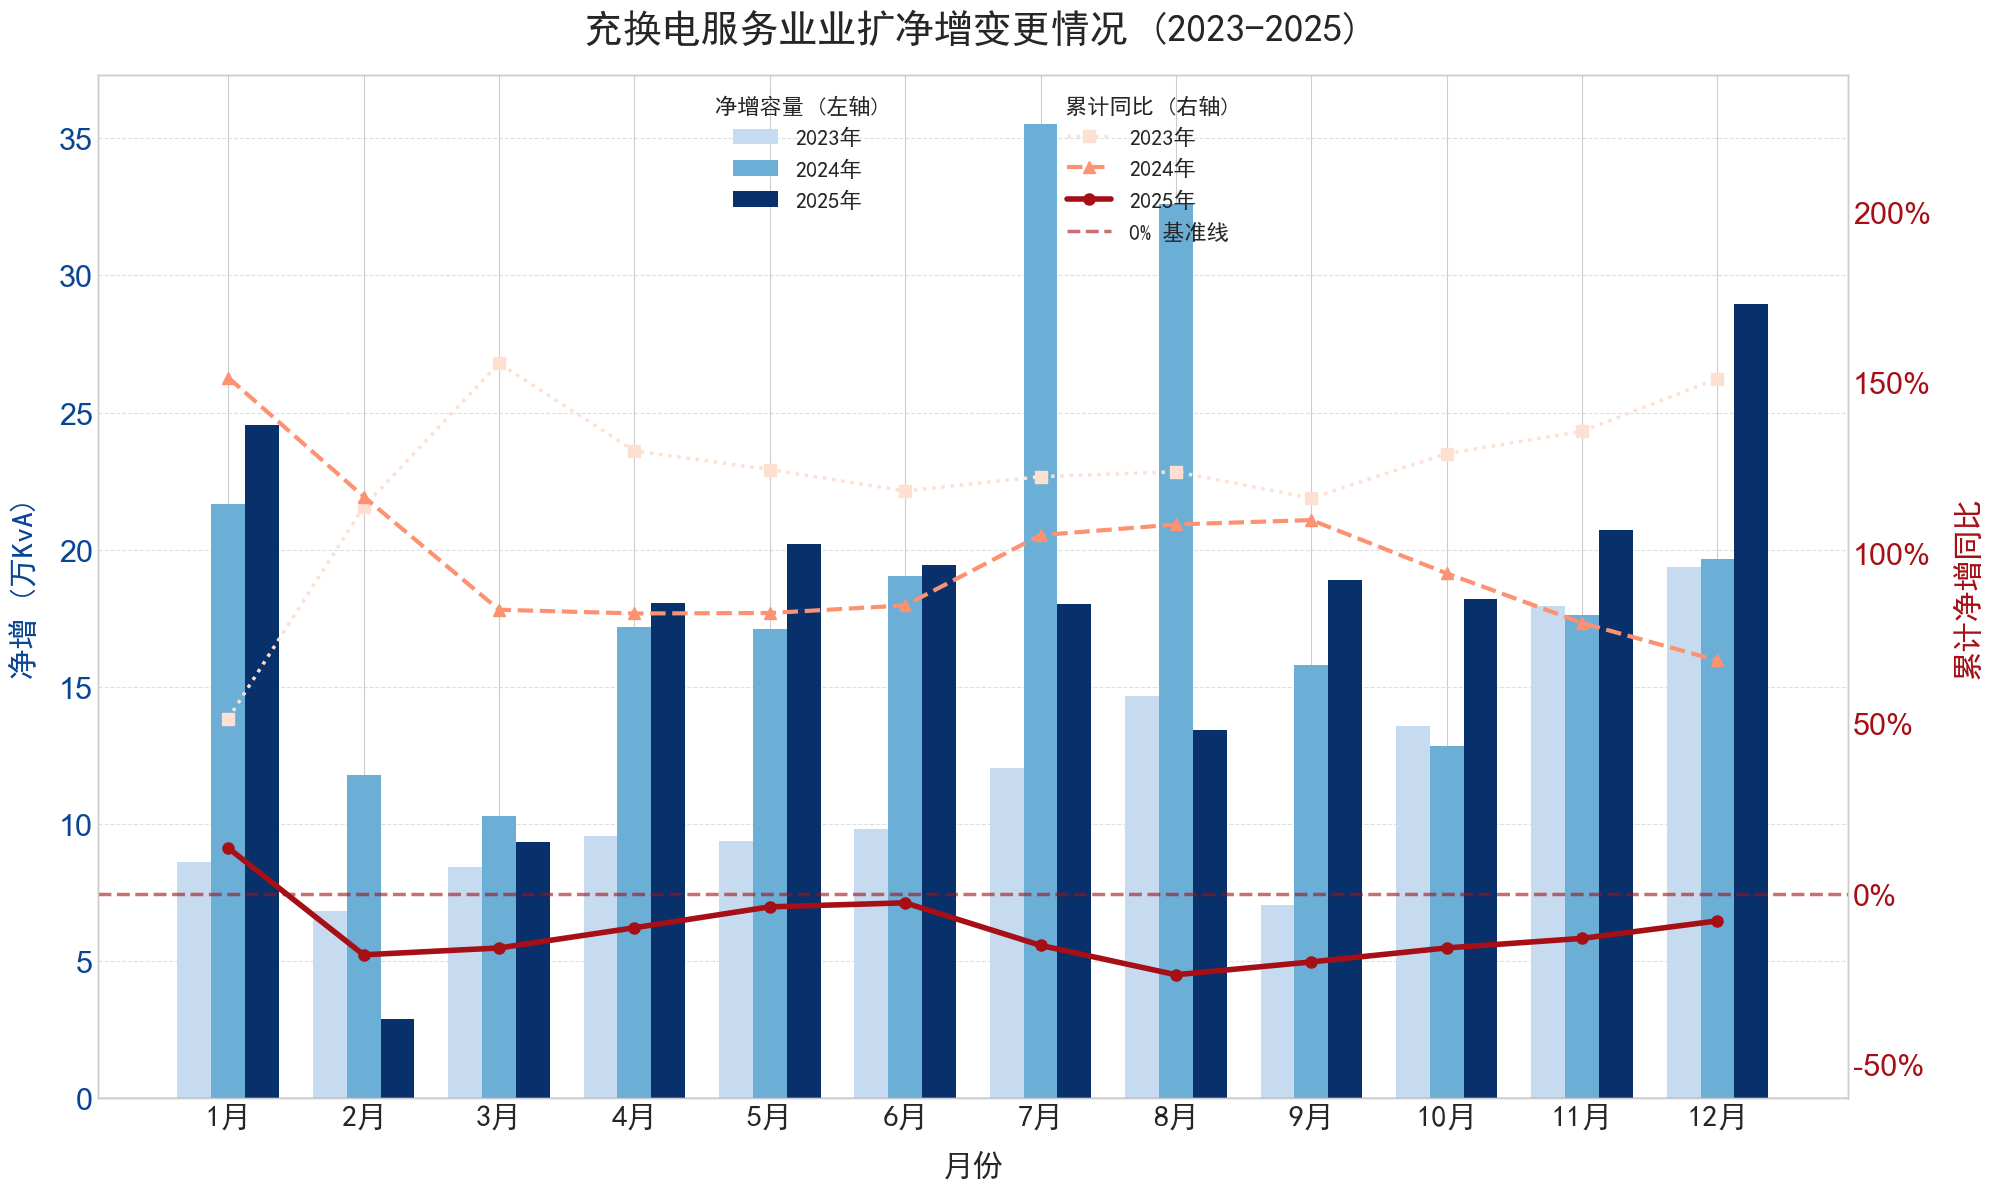

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import Optional, List, Dict, Tuple
from matplotlib import font_manager
import numpy as np
from matplotlib.legend import Legend
import matplotlib.ticker as ticker # 引入ticker用于格式化

# ==============================================================================
# 1. 配置层 (Configuration Layer)
# ==============================================================================
class Config:
    """集中管理所有绘图的配置参数"""
    # --- 基本文件路径配置 ---
    BASE_PATH = Path(r'E:\A智网\业扩分析\26年1月分析\12月业扩月度报告')
    
    # --- 数据源文件 ---
    FILE_NET_INCREASE = BASE_PATH / '25年12月业扩报告_新装增容业扩.xlsx'
    FILE_NET_DECREASE = BASE_PATH / '25年12月业扩报告_减容销户业扩.xlsx'
    FILE_YOY_TREND = BASE_PATH / '业扩月度累计净增容量趋势分析.xlsx'

    # --- 目标行业与输出配置 ---
    TARGET_CATEGORY_NAME = '   其中：充换电服务业' 
    CHART_TITLE_NAME = '充换电服务业' 
    OUTPUT_IMAGE_FILE = BASE_PATH / f'附录图/{CHART_TITLE_NAME}_分析图.png'

    # --- Excel工作表名称 ---
    SHEET_NET_INC_CAP = '完成新装增容_容量'
    SHEET_NET_DEC_CAP = '完成减容销户_容量'
    SHEET_YOY_TREND = '累计净增容量同比'
    
    # --- 图表文本配置 ---
    CHART_TITLE = f'{CHART_TITLE_NAME}业扩净增变更情况 (2023-2025)'
    X_AXIS_LABEL = '月份'
    
    # Y轴1 (左侧): 净增容量
    Y1_AXIS_LABEL = '净增 (万KvA)'
    Y1_AXIS_COLOR = '#084594' # 深蓝色
    
    # Y轴2 (右侧): 累计同比
    Y2_AXIS_LABEL = '累计净增同比'
    Y2_AXIS_COLOR = '#A50F15' # 深红色

    # --- 【关键】在这里修改Y轴范围 ---
    Y2_AXIS_UPPER_LIMIT = 2.0  # 200%
    Y2_AXIS_LOWER_LIMIT = -0.5  # -50%

    # --- 字体配置 ---
    TARGET_FONT = 'SimHei'
    CHART_TITLE_FONTSIZE = 28
    AXIS_LABEL_FONTSIZE = 22
    TICK_LABEL_FONTSIZE = 22
    LEGEND_FONTSIZE = 16
    LEGEND_TITLE_FONTSIZE = 16

# ==============================================================================
# 2. 辅助函数层 (Helper Functions)
# ==============================================================================

def find_specific_font(font_name: str) -> Optional[font_manager.FontProperties]:
    """在系统中严格查找指定的字体文件"""
    print(f"正在严格查找指定的字体: '{font_name}'...")
    font_files = font_manager.fontManager.ttflist
    for font_file in font_files:
        if font_file.name == font_name:
            # print(f"成功找到字体 '{font_name}'，路径: {font_file.fname}")
            return font_manager.FontProperties(fname=font_file.fname)
    print(f"[致命错误] 未能在系统中找到指定的字体 '{font_name}'。")
    return None

def preprocess_net_increase_data(file_new_inc: Path, file_dec_term: Path, sheet_inc: str, sheet_dec: str, target_category: str) -> Optional[pd.DataFrame]:
    """读取并预处理“月度净增容量”数据"""
    print("开始读取和预处理【月度净增容量】数据...")
    try:
        df_inc = pd.read_excel(file_new_inc, sheet_name=sheet_inc, index_col='分类')
        df_dec = pd.read_excel(file_dec_term, sheet_name=sheet_dec, index_col='分类')
        df_inc.columns = df_inc.columns.map(str)
        df_dec.columns = df_dec.columns.map(str)
        
        common_cols = df_inc.columns.intersection(df_dec.columns)
        net_increase_df = df_inc[common_cols].subtract(df_dec[common_cols], fill_value=0)
        net_increase_df = net_increase_df.reset_index()
        
        target_data = net_increase_df[net_increase_df['分类'].str.strip() == target_category.strip()]
        if target_data.empty:
            print(f"[错误] 在【月度净增容量】数据中未找到目标分类: '{target_category}'")
            return None
            
        long_df = target_data.iloc[0].drop('分类').reset_index()
        long_df.columns = ['年月', '净增容量']
        long_df = long_df[long_df['年月'].str.match(r'^\d{6}$')].copy()
        long_df['净增容量'] = pd.to_numeric(long_df['净增容量'], errors='coerce') / 10000
        long_df['年份'] = long_df['年月'].str[:4]
        long_df['月份'] = long_df['年月'].str[4:].astype(int)
        
        target_years = ['2023', '2024', '2025']
        long_df = long_df[long_df['年份'].isin(target_years)]
        
        return long_df.pivot(index='月份', columns='年份', values='净增容量')
    except Exception as e:
        print(f"[致命错误] 处理【月度净增容量】数据时出错: {e}")
        return None

def preprocess_yoy_data(file_path: Path, sheet_name: str, target_category: str) -> Optional[Tuple[pd.DataFrame, List[Dict]]]:
    """读取、预处理并截断“累计同比”数据"""
    print("开始读取和预处理【累计同比】数据...")
    try:
        if not file_path.exists():
            print(f"[致命错误] 输入文件不存在: {file_path}")
            return None, None
            
        df_wide = pd.read_excel(file_path, sheet_name=sheet_name).copy()
        df_target = df_wide[df_wide['分类'].str.strip() == target_category.strip()].copy()
        if df_target.empty:
            print(f"[错误] 在文件中未找到目标分类: '{target_category}'。")
            return None, None
            
        id_vars = ['序号', '分类']
        value_vars = [col for col in df_target.columns if col not in id_vars]
        df_long = df_target.melt(id_vars=id_vars, value_vars=value_vars, var_name='年月', value_name='同比增长率_str')
        
        df_long.loc[:, '同比增长率'] = df_long['同比增长率_str'].astype(str).str.rstrip('%').replace('N/A', pd.NA)
        df_long.loc[:, '同比增长率'] = pd.to_numeric(df_long['同比增长率'], errors='coerce') / 100.0
        
        df_long.loc[:, '年份'] = df_long['年月'].str[:4]
        df_long.loc[:, '月份'] = df_long['年月'].str[4:].astype(int)
        
        target_years = ['2023', '2024', '2025']
        df_long = df_long[df_long['年份'].isin(target_years)].copy()
        
        annotations = []
        df_long['同比增长率_capped'] = df_long['同比增长率']

        for index, row in df_long.iterrows():
            original_value = row['同比增长率']
            if pd.notna(original_value):
                capped_value = original_value
                if original_value > Config.Y2_AXIS_UPPER_LIMIT:
                    capped_value = Config.Y2_AXIS_UPPER_LIMIT
                    annotations.append({'x': row['月份'], 'y': capped_value, 'text': f'{original_value:.0%}'})
                elif original_value < Config.Y2_AXIS_LOWER_LIMIT:
                    capped_value = Config.Y2_AXIS_LOWER_LIMIT
                    annotations.append({'x': row['月份'], 'y': capped_value, 'text': f'{original_value:.0%}'})
                
                df_long.at[index, '同比增长率_capped'] = capped_value
        
        plot_df_capped = df_long.pivot(index='月份', columns='年份', values='同比增长率_capped')
        
        print("数据截断与重塑完成。")
        return plot_df_capped, annotations

    except Exception as e:
        print(f"[致命错误] 处理【累计同比】数据时出错: {e}")
        return None, None

# ==============================================================================
# 3. 主流程 (Main Logic)
# ==============================================================================
def main():
    """主执行函数"""
    
    # --- 字体设置 ---
    base_font_prop = find_specific_font(Config.TARGET_FONT)
    if base_font_prop is None: return
    font_path = base_font_prop.get_file()
    if not font_path: return
    title_font = font_manager.FontProperties(fname=font_path, size=Config.CHART_TITLE_FONTSIZE, weight='bold')
    axis_label_font = font_manager.FontProperties(fname=font_path, size=Config.AXIS_LABEL_FONTSIZE)
    tick_label_font = font_manager.FontProperties(fname=font_path, size=Config.TICK_LABEL_FONTSIZE)
    legend_text_font = font_manager.FontProperties(fname=font_path, size=Config.LEGEND_FONTSIZE)
    legend_title_font = font_manager.FontProperties(fname=font_path, size=Config.LEGEND_TITLE_FONTSIZE, weight='bold')
    
    print(f"\n开始生成综合可视化图表: {Config.CHART_TITLE}")
    
    # --- 数据处理 ---
    df_net_increase = preprocess_net_increase_data(Config.FILE_NET_INCREASE, Config.FILE_NET_DECREASE, Config.SHEET_NET_INC_CAP, Config.SHEET_NET_DEC_CAP, Config.TARGET_CATEGORY_NAME)
    df_yoy_capped, annotations = preprocess_yoy_data(Config.FILE_YOY_TREND, Config.SHEET_YOY_TREND, Config.TARGET_CATEGORY_NAME)
    
    if df_net_increase is None or df_yoy_capped is None:
        print("因数据读取或处理失败，无法生成图表。")
        return
    
    # --- 绘图 ---
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax1 = plt.subplots(figsize=(20, 12))
    
    ax2 = ax1.twinx()
    
    years = ['2023', '2024', '2025']
    
    bar_width = 0.25
    index = np.arange(1, 13)
    
    colors1 = {'2023': '#C6DBEF', '2024': '#6BAED6', '2025': '#08306B'}
    
    bar1 = ax1.bar(index - bar_width, df_net_increase.get('2023', 0), bar_width, label='2023年', color=colors1['2023'])
    bar2 = ax1.bar(index, df_net_increase.get('2024', 0), bar_width, label='2024年', color=colors1['2024'])
    bar3 = ax1.bar(index + bar_width, df_net_increase.get('2025', 0), bar_width, label='2025年', color=colors1['2025'])

    colors2 = {'2023': '#FEE0D2', '2024': '#FC9272', '2025': '#A50F15'}
    linestyles = {'2023': ':', '2024': '--', '2025': '-'}
    linewidths = {'2023': 2.5, '2024': 3, '2025': 4}
    markers = {'2023': 's', '2024': '^', '2025': 'o'}

    for year in years:
        if year in df_yoy_capped.columns:
            ax2.plot(df_yoy_capped.index, df_yoy_capped[year], 
                     linestyle=linestyles[year], linewidth=linewidths[year],
                     color=colors2[year], marker=markers[year], markersize=8,
                     label=f'{year}年')

    for ann in annotations:
        ax2.annotate(ann['text'], xy=(ann['x'], ann['y']), xytext=(0, 15), textcoords='offset points', ha='center', va='bottom',
                     fontproperties=font_manager.FontProperties(fname=font_path, size=14, weight='bold'), color='blue',
                     arrowprops=dict(arrowstyle='->', color='blue'))

    # --- 美化 ---
    ax1.set_title(Config.CHART_TITLE, fontproperties=title_font, pad=25)
    ax1.set_xlabel(Config.X_AXIS_LABEL, fontproperties=axis_label_font, labelpad=15)
    
    ax1.set_ylabel(Config.Y1_AXIS_LABEL, fontproperties=axis_label_font, color=Config.Y1_AXIS_COLOR, labelpad=15)
    ax1.tick_params(axis='y', labelcolor=Config.Y1_AXIS_COLOR, labelsize=Config.TICK_LABEL_FONTSIZE)
    # 左轴网格线
    ax1.grid(True, which='major', axis='y', linestyle='--', color='#BDC3C7', alpha=0.5)

    ax2.set_ylabel(Config.Y2_AXIS_LABEL, fontproperties=axis_label_font, color=Config.Y2_AXIS_COLOR, labelpad=15)
    ax2.tick_params(axis='y', labelcolor=Config.Y2_AXIS_COLOR, labelsize=Config.TICK_LABEL_FONTSIZE)
    
    # 智能调整Y轴下限
    y_upper = Config.Y2_AXIS_UPPER_LIMIT * 1.2
    y_lower = 0
    if Config.Y2_AXIS_LOWER_LIMIT < 0:
        y_lower = Config.Y2_AXIS_LOWER_LIMIT * 1.2
    else:
        y_lower = - (y_upper * 0.1)
        
    ax2.set_ylim(y_lower, y_upper)
    ax2.yaxis.set_major_formatter(plt.FuncFormatter('{:.0%}'.format))
    ax2.grid(False) # 关闭右轴网格线，避免混乱

    ax1.set_xticks(index)
    ax1.set_xticklabels([f'{i}月' for i in range(1, 13)], fontproperties=tick_label_font)
    
    # --- 【核心修改】强化0刻度线 ---
    # 1. 左轴的0线 (黑色，细实线)
    ax1.axhline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
    
    # 2. 右轴的0线 (红色，粗虚线，明确标识)
    # 使用与右轴相同的颜色，增加辨识度
    ax2.axhline(0, color=Config.Y2_AXIS_COLOR, linestyle='--', linewidth=2.5, alpha=0.6, label='0% 基准线')

    # --- 图例 ---
    leg1 = Legend(ax1, [bar1, bar2, bar3], ['2023年', '2024年', '2025年'],
                  title='净增容量 (左轴)', prop=legend_text_font,
                  loc='upper center', bbox_to_anchor=(0.4, 1))
    leg1.get_title().set_font_properties(legend_title_font)
    ax1.add_artist(leg1)

    lines2, labels2 = ax2.get_legend_handles_labels()
    leg2 = Legend(ax1, lines2, labels2,
                  title='累计同比 (右轴)', prop=legend_text_font,
                  loc='upper center', bbox_to_anchor=(0.6, 1))
    leg2.get_title().set_font_properties(legend_title_font)
    ax1.add_artist(leg2)
    
    fig.tight_layout()
    
    # 确保输出目录存在
    Config.OUTPUT_IMAGE_FILE.parent.mkdir(parents=True, exist_ok=True)
    
    try:
        plt.savefig(Config.OUTPUT_IMAGE_FILE, dpi=500, bbox_inches='tight')
        print(f"\n图表已成功保存到: {Config.OUTPUT_IMAGE_FILE}")
    except Exception as e:
        print(f"\n[错误] 保存图表失败: {e}")
    plt.show()

if __name__ == '__main__':
    main()